<a href="https://colab.research.google.com/github/SG-Hangaan/Kaggle-Competition-Solutions/blob/main/Kaggle_House_Prices_AdvancedRegressionTechniques_Finals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import tensorflow and checking the versions
import tensorflow as tf
print(tf.__version__)

2.14.0


Download Kaggle Challenge Dataset

In [2]:
#Install dependencies
!pip install kaggle

In [3]:
!pwd

/content


In [4]:
!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/
#Changing permission
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#Getting Kaggle.JSON file from Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 121MB/s]


Extracting the Dataset

In [9]:
!unzip 'house-prices-advanced-regression-techniques.zip'

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


Removing ZIP File

In [10]:
!rm -rf 'house-prices-advanced-regression-techniques.zip'

Importing important packages

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error,r2_score

# Input data files are available in the "../input/" directory.
from subprocess import check_output
print(check_output(["ls", "../content"]).decode("utf8"))

data_description.txt
drive
sample_data
sample_submission.csv
test.csv
train.csv



Read and Reshape the dataset

In [12]:
# Read training and test data files
path_train='train.csv'
path_test='test.csv'
df=pd.read_csv(path_train,index_col='Id')
df_t=pd.read_csv(path_test,index_col='Id')
df_t.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  

[5 rows x 79 columns]

In [13]:
df_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearB

In [14]:
#pre_process function train and test dataframes
def pre_process(df):
    df=df.drop(['MiscFeature','PoolQC','Fence','Alley'],axis=1)
    num_df=df.select_dtypes(include='number')
    num_cols=num_df.columns
    for col in num_cols:
        df[col]=df[col].fillna(df[col].median())
    str_df=df.select_dtypes(include='object')
    str_cols=str_df.columns
    for col in str_cols:
        df[col]=df[col].fillna(df['LotShape'].value_counts().idxmax())
    for col in str_cols:
        df[col]=pd.factorize(df[col])[0]
    return df

ptr_df=pre_process(df)
ptr_df.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  LandContour  \
Id                                                                              
1           60         0         65.0     8450       0         0            0   
2           20         0         80.0     9600       0         0            0   
3           60         0         68.0    11250       0         1            0   
4           70         0         60.0     9550       0         1            0   
5           60         0         84.0    14260       0         1            0   

    Utilities  LotConfig  LandSlope  ...  EnclosedPorch  3SsnPorch  \
Id                                   ...                             
1           0          0          0  ...              0          0   
2           0          1          0  ...              0          0   
3           0          0          0  ...              0          0   
4           0          2          0  ...            272          0   
5           0          1          0  ...              0          0   

    ScreenPorch  PoolArea  MiscVal  MoSold  YrSold  SaleType  SaleCondition  \
Id                                                                            
1             0         0        0       2    2008         0              0   
2             0         0        0       5    2007         0              0   
3             0         0        0       9    2008         0              0   
4             0         0        0       2    2006         0              1   
5             0         0        0      12    2008         0              0   

    SalePrice  
Id             
1      208500  
2      181500  
3      223500  
4      140000  
5      250000  

[5 rows x 76 columns]

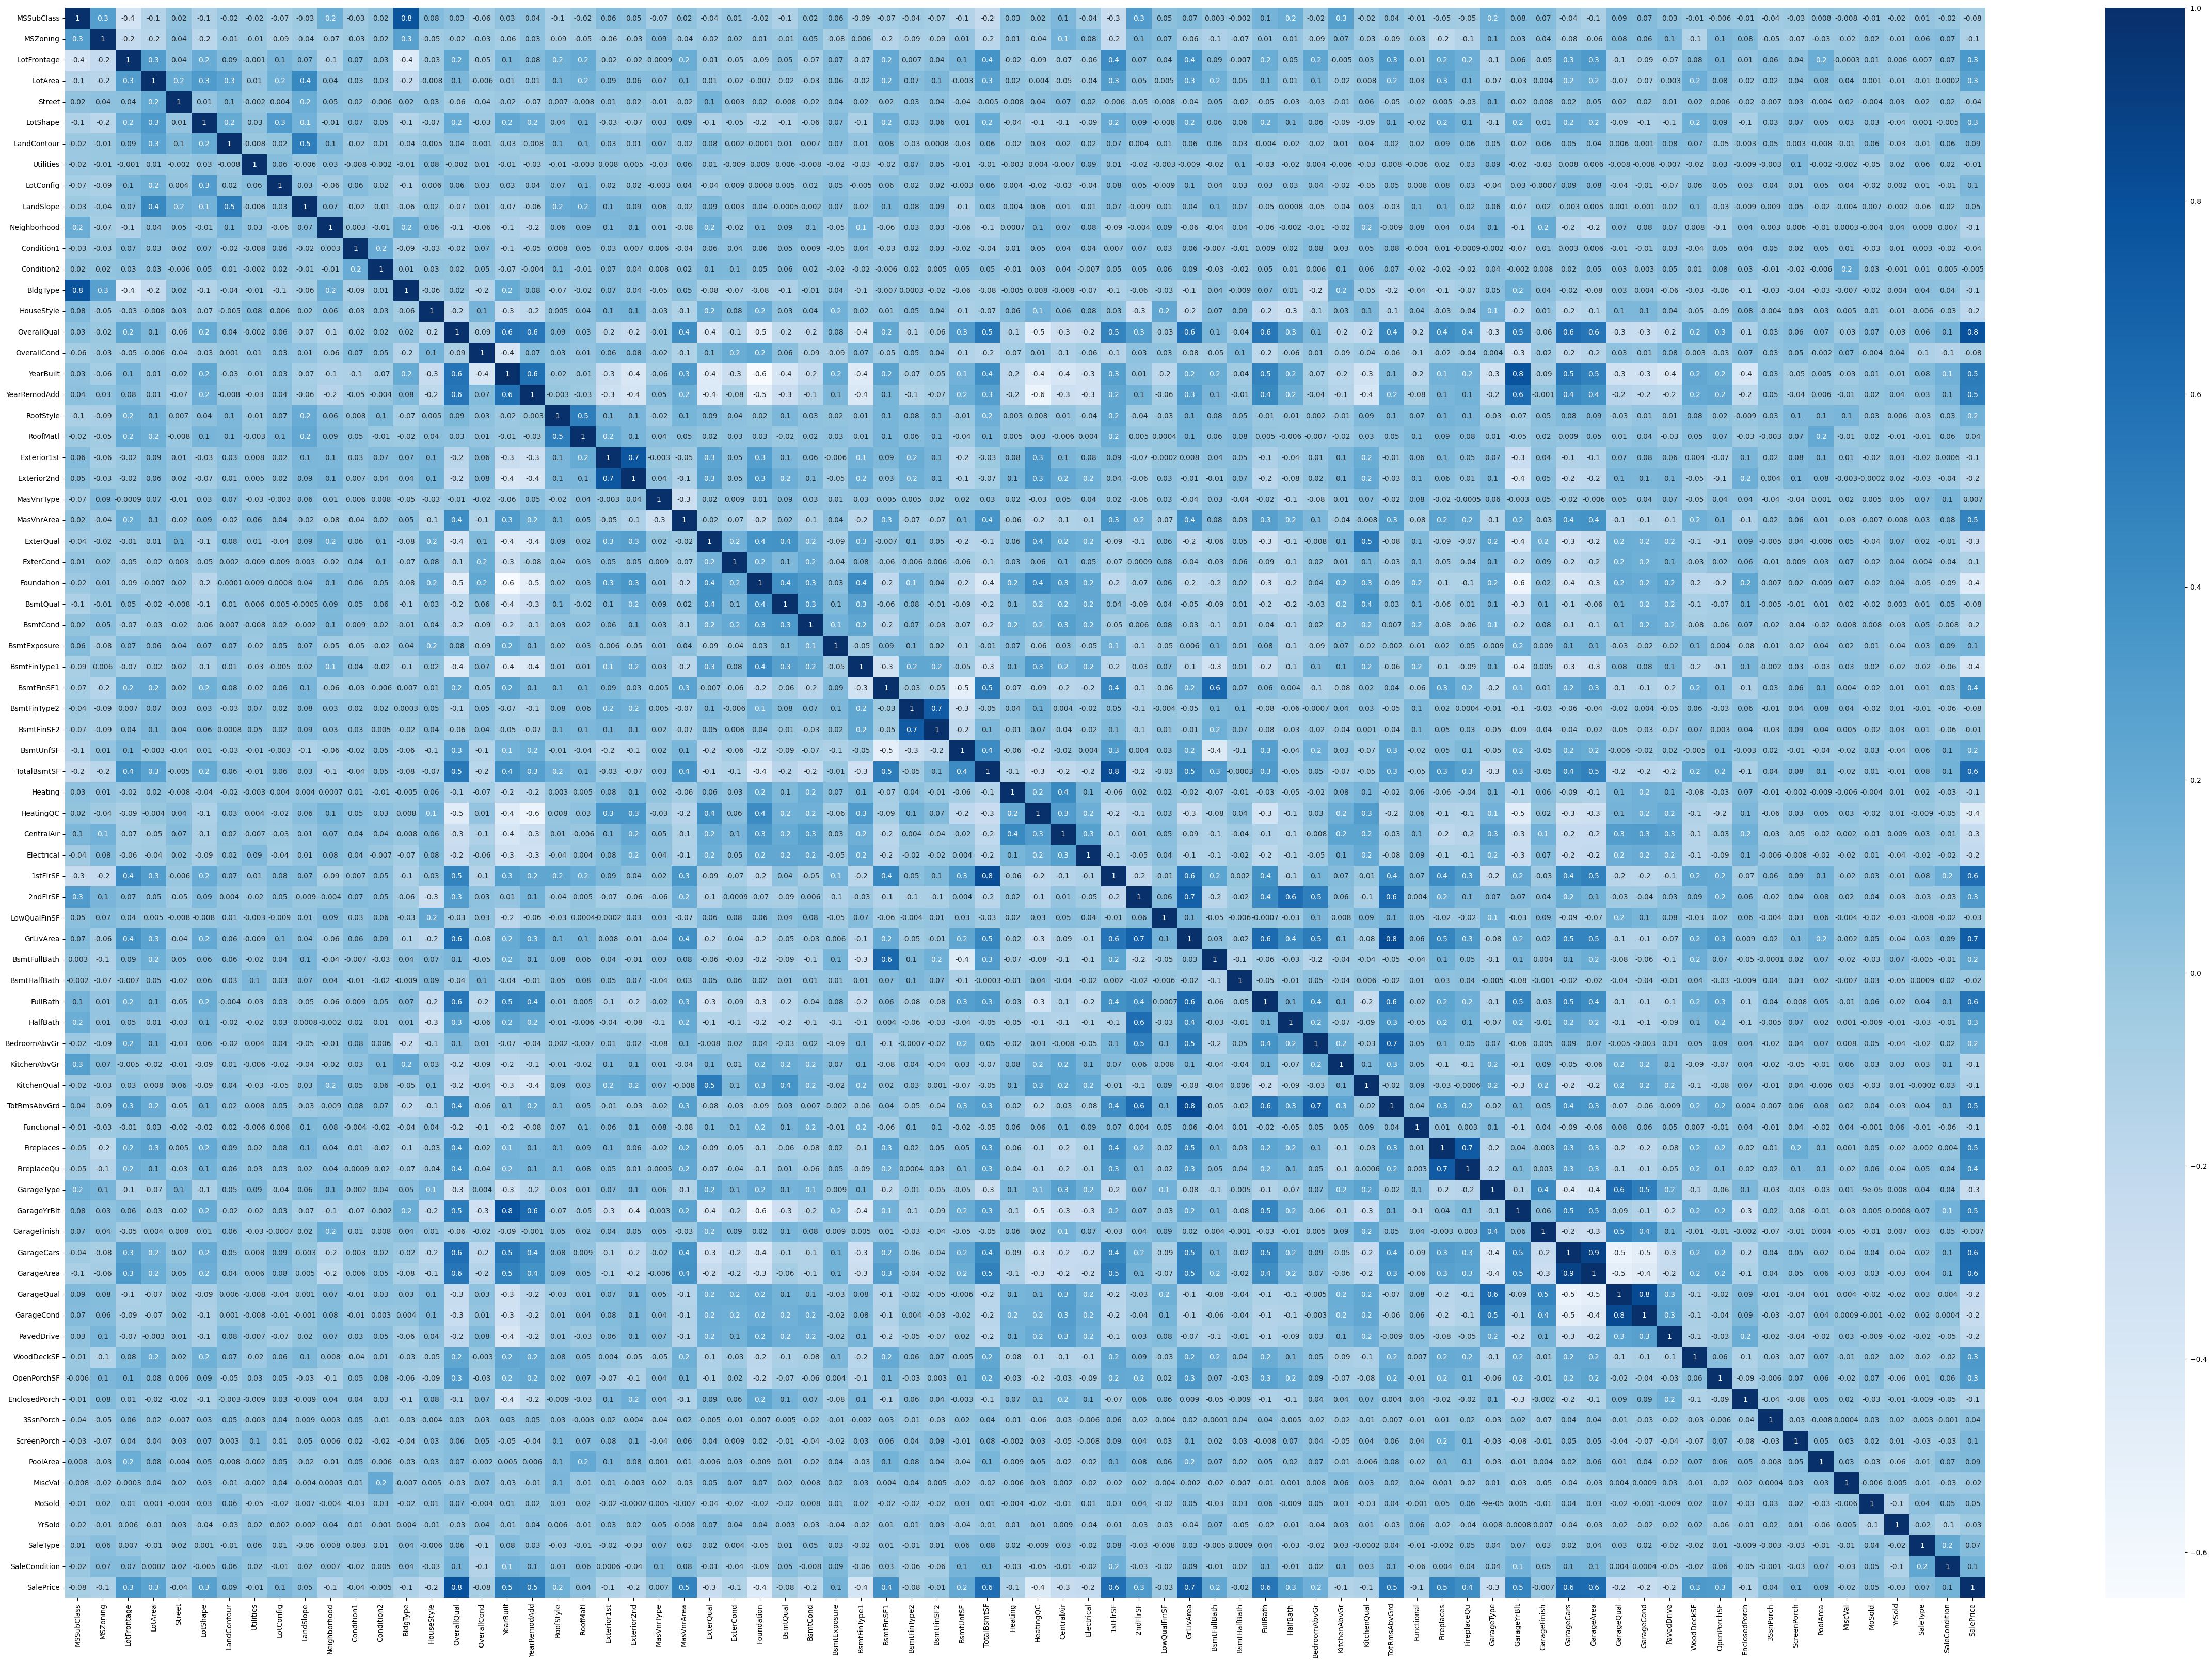

In [15]:
cor=ptr_df.corr()
plt.figure(figsize=(60,40))
sns.heatmap(data=cor,annot=True,cmap='Blues',fmt='.1g')
plt.show()

In [16]:
eda_cols=['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','SalePrice']
edadf=df[eda_cols]
edadf

OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  TotalBsmtSF  1stFlrSF  \
Id                                                                              
1               7       2003          2003       196.0          856       856   
2               6       1976          1976         0.0         1262      1262   
3               7       2001          2002       162.0          920       920   
4               7       1915          1970         0.0          756       961   
5               8       2000          2000       350.0         1145      1145   
...           ...        ...           ...         ...          ...       ...   
1456            6       1999          2000         0.0          953       953   
1457            6       1978          1988       119.0         1542      2073   
1458            7       1941          2006         0.0         1152      1188   
1459            5       1950          1996         0.0         1078      1078   
1460            5       1965          1965         0.0         1256      1256   

      GrLivArea  FullBath  TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  \
Id                                                                             
1          1710         2             8           0       2003.0           2   
2          1262         2             6           1       1976.0           2   
3          1786         2             6           1       2001.0           2   
4          1717         1             7           1       1998.0           3   
5          2198         2             9           1       2000.0           3   
...         ...       ...           ...         ...          ...         ...   
1456       1647         2             7           1       1999.0           2   
1457       2073         2             7           2       1978.0           2   
1458       2340         2             9           2       1941.0           1   
1459       1078         1             5           0       1950.0           1   
1460       1256         1             6           0       1965.0           1   

      GarageArea  SalePrice  
Id                           
1            548     208500  
2            460     181500  
3            608     223500  
4            642     140000  
5            836     250000  
...          ...        ...  
1456         460     175000  
1457         500     210000  
1458         252     266500  
1459         240     142125  
1460         276     147500  

[1460 rows x 14 columns]

<Figure size 2000x1500 with 0 Axes>

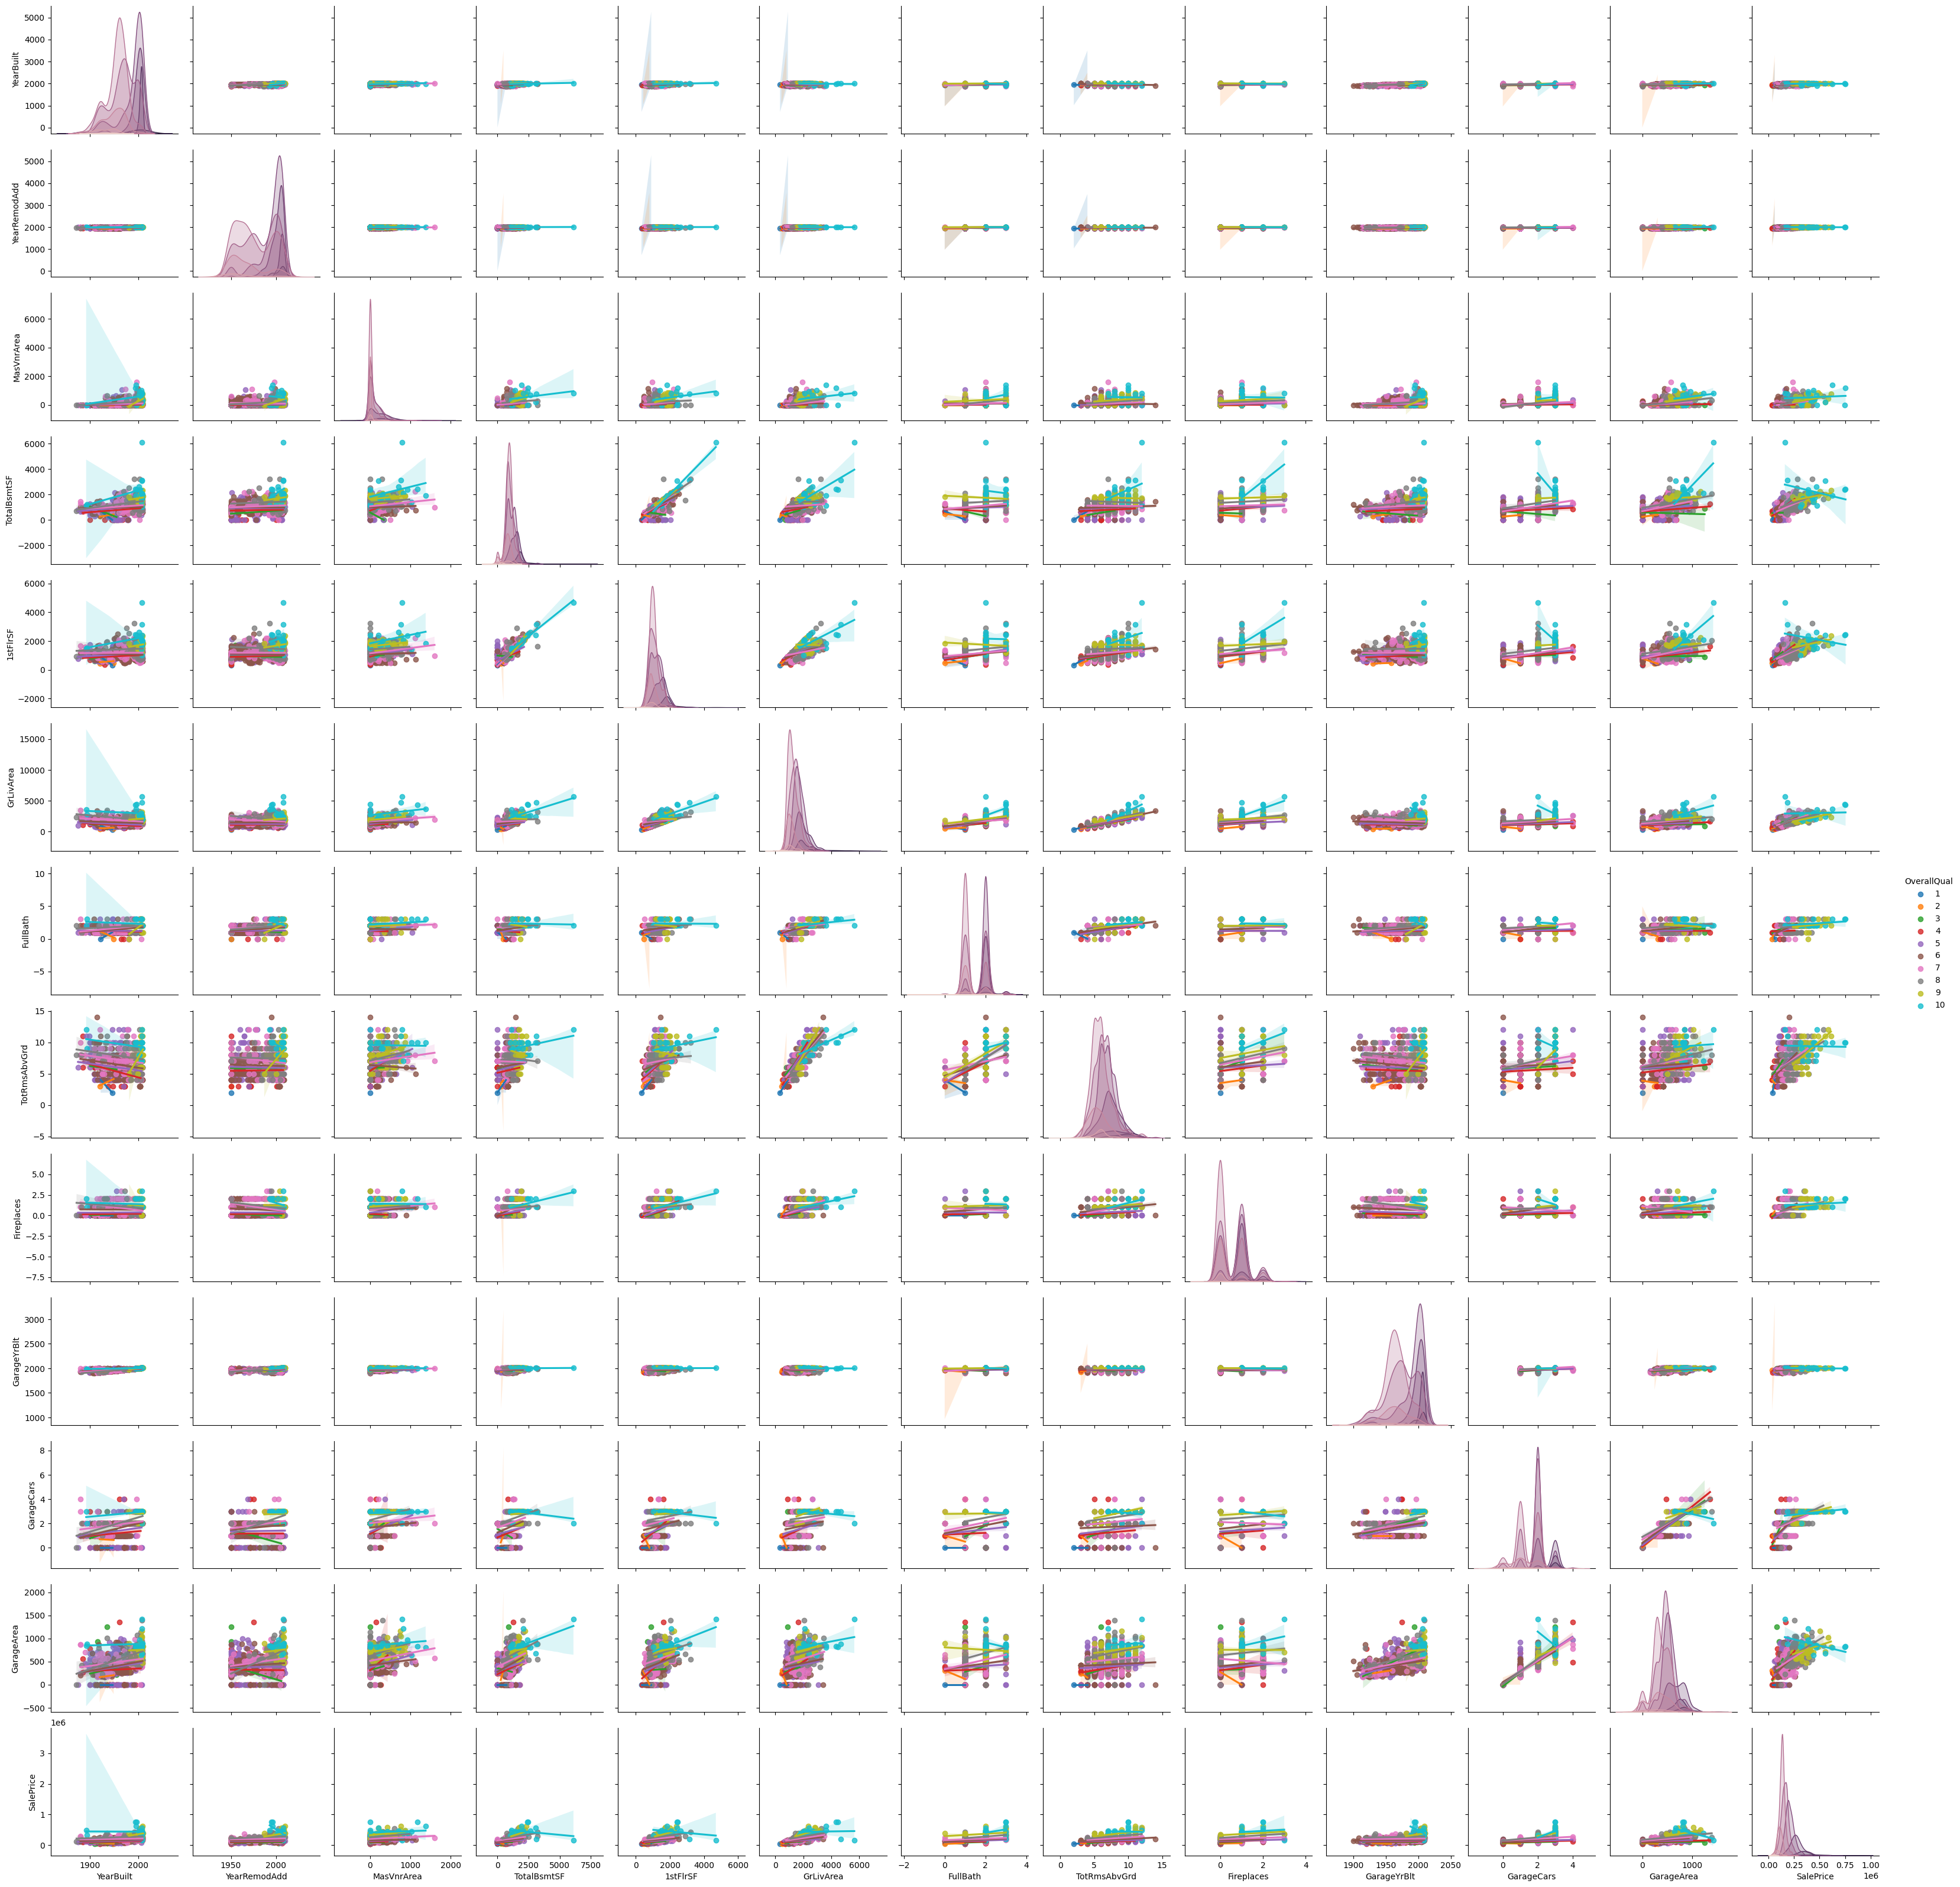

In [17]:
plt.figure(figsize=(20,15))
sns.pairplot(data=edadf,diag_kind='kde',hue='OverallQual',kind='reg')
plt.show()

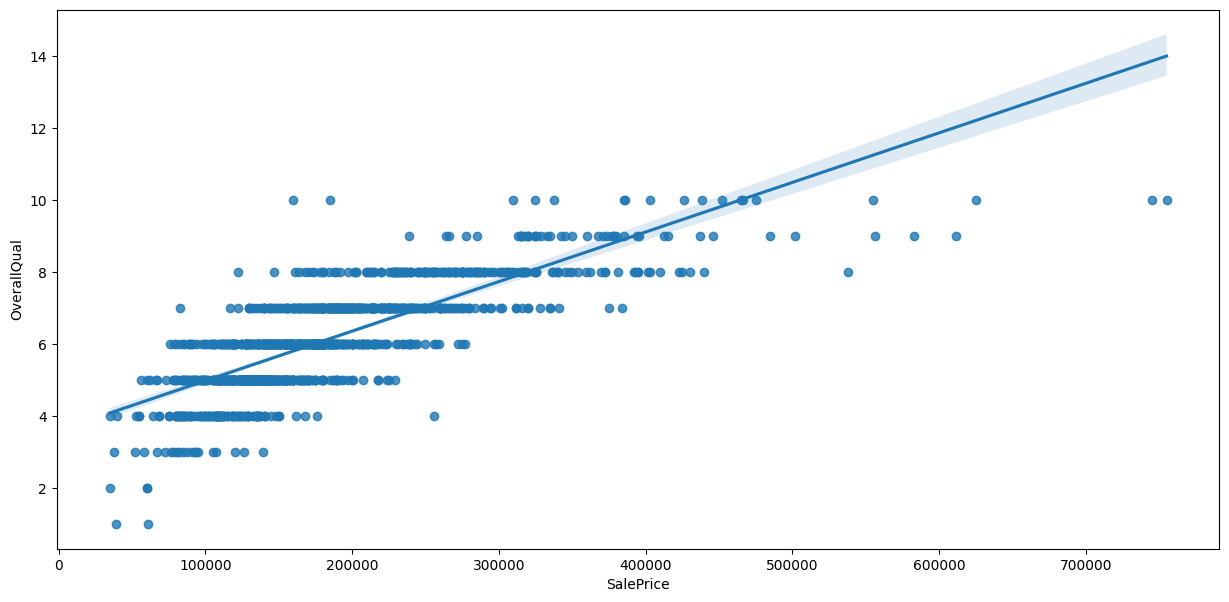

In [18]:
plt.figure(figsize=(15,7))
sns.regplot(data=edadf,x='SalePrice',y='OverallQual')
plt.show()

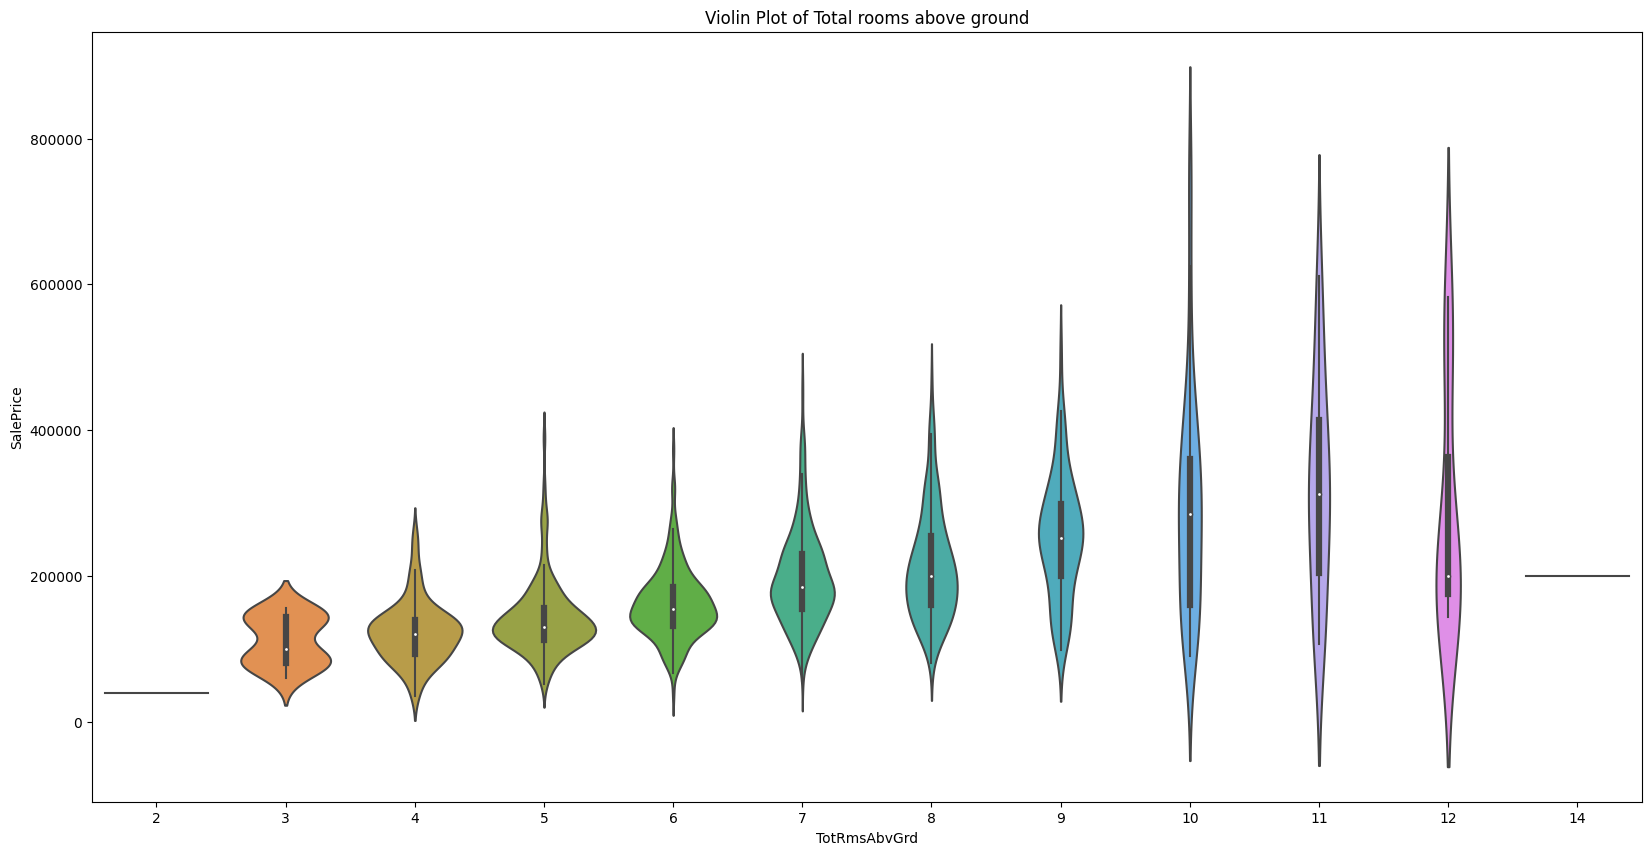

In [19]:
plt.figure(figsize=(20,10))
sns.violinplot(data=edadf,x='TotRmsAbvGrd',y='SalePrice')
plt.title('Violin Plot of Total rooms above ground')
plt.show()

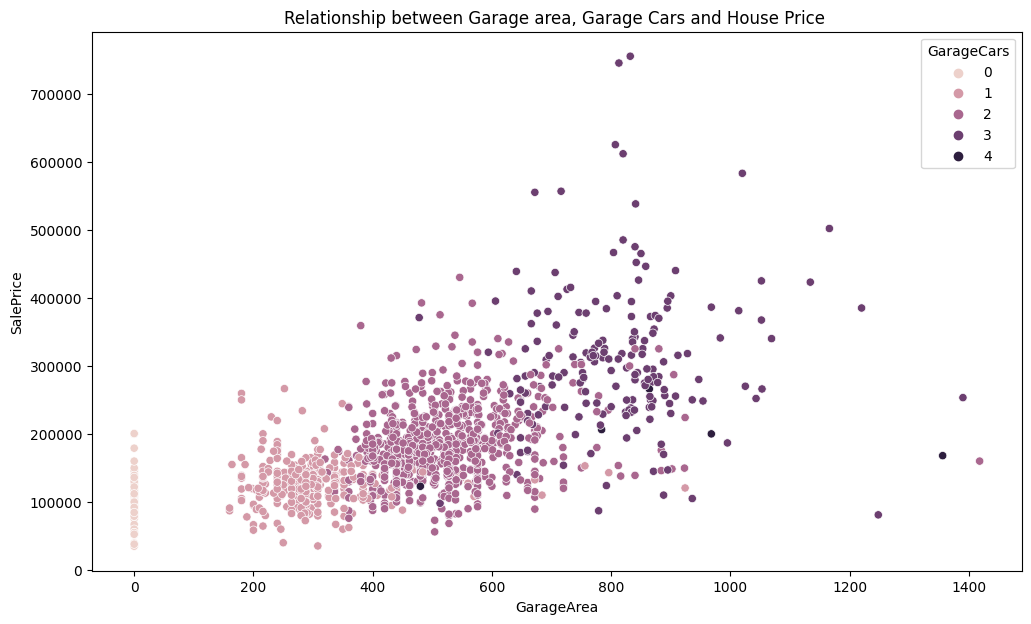

In [20]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=edadf,x='GarageArea',y='SalePrice',hue='GarageCars')
plt.title('Relationship between Garage area, Garage Cars and House Price ')
plt.show()

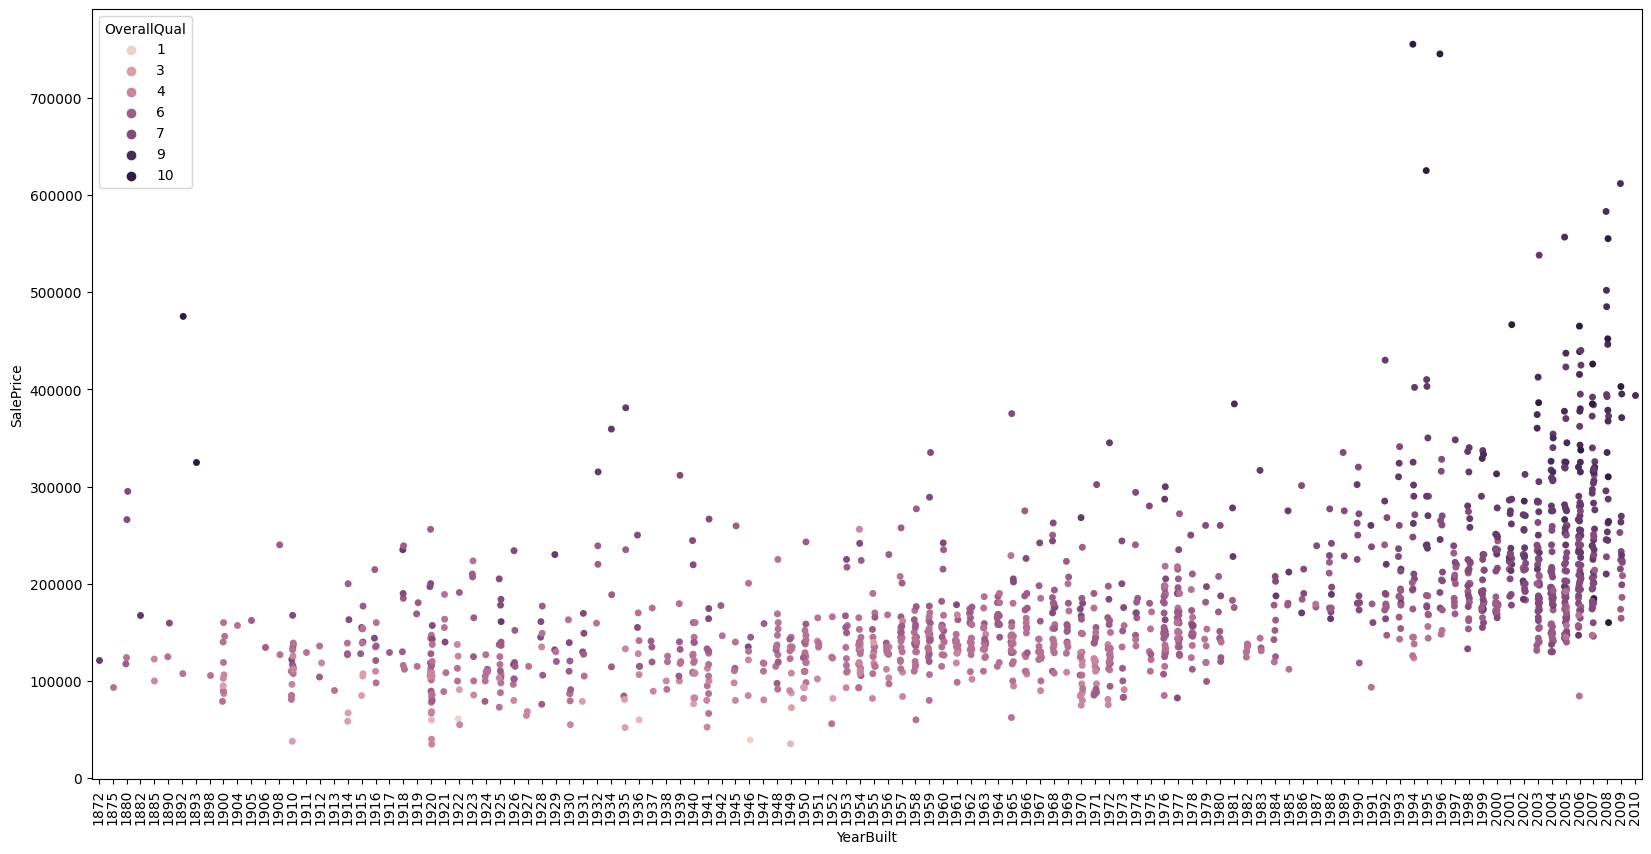

In [21]:
plt.figure(figsize=(20,10))
sns.stripplot(data=edadf,x='YearBuilt',y='SalePrice',hue='OverallQual')
plt.xticks(rotation=90)
plt.show()

In [22]:
#process test data
pts_df=pre_process(df_t)
pts_df.head()

MSSubClass  MSZoning  LotFrontage  LotArea  Street  LotShape  \
Id                                                                   
1461          20         0         80.0    11622       0         0   
1462          20         1         81.0    14267       0         1   
1463          60         1         74.0    13830       0         1   
1464          60         1         78.0     9978       0         1   
1465         120         1         43.0     5005       0         1   

      LandContour  Utilities  LotConfig  LandSlope  ...  OpenPorchSF  \
Id                                                  ...                
1461            0          0          0          0  ...            0   
1462            0          0          1          0  ...           36   
1463            0          0          0          0  ...           34   
1464            0          0          0          0  ...           36   
1465            1          0          0          0  ...           82   

      EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  MoSold  \
Id                                                                       
1461              0          0          120         0        0       6   
1462              0          0            0         0    12500       6   
1463              0          0            0         0        0       3   
1464              0          0            0         0        0       6   
1465              0          0          144         0        0       1   

      YrSold  SaleType  SaleCondition  
Id                                     
1461    2010         0              0  
1462    2010         0              0  
1463    2010         0              0  
1464    2010         0              0  
1465    2010         0              0  

[5 rows x 75 columns]

In [23]:
X=ptr_df.drop('SalePrice',axis=1)
X.head()
y=df['SalePrice']

In [24]:
model=GradientBoostingRegressor(n_estimators=700)
model.fit(X,y)
pred=model.predict(X)
mape=mean_absolute_percentage_error(y,pred)
r2=r2_score(y,pred)
print(mape,r2)

0.026330064881011337 0.9955630030863637


In [25]:
ts_pred=model.predict(pts_df)
end_pred=pd.DataFrame(ts_pred,index=df_t.index)
end_pred.columns=['SalePrice']
end_pred.to_csv('submission.csv',sep=',')
end_pred.head()

SalePrice
Id                 
1461  136364.809457
1462  164530.395413
1463  194839.765459
1464  191105.440224
1465  176190.841831

In [26]:
#Submitting the results on Kaggle
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "Message"

100% 33.7k/33.7k [00:00<00:00, 51.8kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques